# MODELISATION D'UNE PIECE

In [23]:
# Commençons par charger les librairies

import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go
from tqdm import tqdm
import os
from IPython.display import HTML
# Pour vérifier si les matrices creuses sont vraiment plus efficaces que les matrices denses, on vérifie la compléxité en temps.
from datetime import datetime
import time

Nous allons étudier une maison avec des murs extérieurs et intérieurs, des radiateurs et des fenêtres.

Le but de l'étude va être d'observer l'évolution de la température en fonction de certains paramètres des matériaux de la pièce.

Nous allons également chercher à placer de manière optimale des radiateurs et climatiseurs dans une pièce.

Enfin nous ferons une étude 3 D

In [24]:
# Définissons l'ensemble des variables

# Pas d'espace et de temps constant (dans un premier temps)
dx, dy, dz, dt = [1,1,1,1]


# Températures
Th, Tb, Td, Tg, T_in, T_rad = [10, 10, 10, 10, 20, 30]
                                # On définit des températures différentes autour de la pièce
                                #     Th   : température bord supérieur
                                #     Tb   : température bord inférieur
                                #     Td   : température bord droit
                                #     Tg   : température bord gauche
                                #     T_in : température à l'intérieur de la pièce
    
# Conductivités thermiques
matiere = {
            "mur"   :  0.001,
            "air"   :  0.0262,
            "vitre" :  10       # On augmente le coefficient associé à la conductivité thermique de la vitre pour mieux voir le phénomène
          }

# Epaisseur d'un mur
e = 2                           # On définit l'épaisseur du mur en nombre de points
 


# Pour imposer fortement les conditions au bord, on définit une constante M très grande devant les autres variables du problème
M = 10e5

In [3]:
# Fonctions pour manipuler les matrices / vecteurs

def matrix_to_vec(M):          # Entrée : M une matrice en entrée
    return (np.ravel(M))       # Sortie : un vecteur qui contient toutes les valeurs de la matrice applanie (ligne par ligne)

def vec_to_matrix(k,Nx,Ny):              # Entrée : k un vecteur, Nx nombre de points de la matrice suivant x, Ny suivant y
    return np.array(k).reshape(Ny,Nx)    # Sortie : une matrice de taille (Ny, Nx) qui contient les valeurs de k

In [4]:
# Pour représenter au mieux la propagation de la chaleur en fonction du temps, nous avons choisi la heatmap.
# On code une fonction qui prend en entrée les températures en chaque point pour renvoyé un graphique propre en sortie.

def affichage(T,col=False):
    
    # Entrée : 
    #          - T        : une matrice qui contient les valeurs de températures en tous les points de la pièce.
    #          - with_nbr : un booléen qui vaut TRUE si on souhaite que les nombres soient afficher et FALSE sinon.
    # Sortie :
    #          - Rien n'est retourné (une heatmap est print)
    
    if col : 
        sns.heatmap((np.round(T)),cmap="vlag")
    else:
        sns.heatmap((np.round(T)))

In [5]:
# Fonction qui rend la position des bords de la pièce

def k_border(Nx,Ny):
    
    # Entrée : 
    #          - Nx, Ny la dimension de la pièce (en nombre de points)
    # Sortie :
    #          - res : un vecteur de booléen qui indique pour chaque point si il se situe sur la bordure
    
    res = []
    for i in list(range(1,Ny*Nx+1)):
        if i <= Nx:
            res.append(True)
        elif i> Nx*(Ny-1):
            res.append(True)
        elif (i%(Nx)==1)|(i%Nx==0):
            res.append(True)
        else :
            res.append(False)
    return np.array(res)

In [6]:
# permet de placer des élements plus spécifiques dans une pièce : radiateurs, ...

def k_stuff(Nx,Ny,center,haut,bas,gauche,droite):
    res = []
    
    for i in list(range(1,Ny*Nx+1)):
        
        if ((i//Nx>=bas) and (i//Nx<=haut)) and (i%(Nx) in range(int(center-gauche),int(center+droite))):
            res.append(True)
        else : 
            res.append(False)
    return np.array(res)

In [7]:
# Fonction qui rend la position des murs de la pièce

def k_wall(Nx, Ny, e):

    # Entrée : 
    #          - Nx, Ny la dimension de la pièce (en nombre de points)
    #          - e l'épaisseur des murs
    # Sortie :
    #          - res : un vecteur de booléen qui indique pour chaque point si il se situe dans un mur
    
    res = []
    for i in list(range(1,Ny*Nx+1)):
        if i <= (Nx*e):
            res.append(True)
        elif i> Nx*Ny-Nx*e:
            res.append(True)
        elif (i%(Nx)<=e)|(i%(Nx)>Nx-e):
            res.append(True)
        else :
            res.append(False)
    return np.array(res)

In [8]:
# permet de définir une maison avec les murs fenêtre etc ...

def house_border(Nx,Ny,e,wall_in,rad_in,window):
    # Entrée : 
    #          - Nx, Ny la dimension de la pièce (en nombre de points)
    #          - e l'épaisseur des murs exterieur
    #          - wall_in : list de dict de mur intérieur
    #          - rad_in : list de dict de radiateur intérieur
    #          - window_in : list de dict de window inttérieur
    #          -
    # Sortie :
    #  
    res_border = k_border(Nx,Ny)
    res_wall = np.array([False]*Nx*Ny)
    res_rad_in = np.array([False]*Nx*Ny)
    res_window = np.array([False]*Nx*Ny)
          
    for wall in wall_in :
        res_wall = res_wall | k_stuff(Nx,Ny,wall["center"],wall["haut"],wall["bas"],wall["gauche"],wall["droite"])
    
    for rad in rad_in :
        res_rad_in = res_rad_in | k_stuff(Nx,Ny,rad["center"],rad["haut"],rad["bas"],rad["gauche"],rad["droite"])
    
    for w in window :
        res_window = res_window | k_stuff(Nx,Ny,w["center"],w["haut"],w["bas"],w["gauche"],w["droite"])
    return {"border":np.array(res_border),
            "wall":np.array(res_wall), 
            "rad":np.array(res_rad_in),
            "window":np.array(res_window)} 

In [9]:
# fonction qui permet d'avoir un formalisme dans la définition d'un radiateur, fenetre etc ...

def instance(center,haut,bas,gauche,droite):
    return {"center":center,
            "haut":haut,
            "bas":bas,
            "gauche":gauche,
           "droite": droite}

In [10]:
# generateur de la matrice A du schema de Euler Implicite
# les élements sont ajoutés dans un ordre de priorité, une fenetre sera devant un mur ...

def generator_A_house(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e):
    A = np.zeros((Nx*Ny,Nx*Ny))
    compute_border = house_border(Nx,Ny,e,wall_in,rad_in,window)
    wall = compute_border["wall"]
    border = compute_border["border"]
    window = compute_border["window"]
    rad = compute_border["rad"]
    length = range(Nx*Ny)
    
    for k,b,w,f,r in list(zip(length,border,wall,window,rad)):
        if b or r:
            A[k,k]=M
        else:
            if f:
                mu = matiere["vitre"]
            elif w:
                mu = matiere["mur"]
            else:
                mu = matiere["air"]
            A[k,k]=dt*(1+2*mu*(1/(dx**2)+1/(dy**2)))
            A[k,k-1]=-mu*dt/(dx**2)
            A[k,k+1]=-mu*dt/(dx**2)
            A[k,k-Nx]=-mu*dt/(dy**2)
            A[k,k+Nx]=-mu*dt/(dy**2)
    return A

In [11]:
# Fonction qui permet de faire des simulations

def simulation_house_1(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e):
    # initialisation de la température 
    compute = house_border(Nx,Ny,e,wall_in,rad_in,window)
    is_border = compute["border"]
    is_rad = compute["rad"]
    T0 = np.array([Temp["in"]]*(Nx*Ny))
    T0[is_border]=Temp["border"]
    T0[is_rad]=Temp["rad"]
    T = [T0.copy()]
    A_inv = np.linalg.inv(generator_A_house(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        Tk_1[is_rad]=Tk_1[is_rad]*M
        T.append(np.dot(A_inv,Tk_1))
    
    return T

In [12]:
# permet d'avoir accès à la moyenne d'une pièce qui a des murs de taille e
def average_room(T):
    # on a fixé e la valeur de 2
    e = 2
    return np.mean(T[e:-e,e:-e])

# Temps de calcul 

In [13]:
Temp = {"in":20,
       "border":10,
       "rad":30}

Nx = 40
Ny = 40

e = 2
wall_in = [instance(Nx/2,Ny-2,Ny-e-1,Nx/2-e-1,Nx/2-e+1),instance(Nx/2,e,1,Nx/2-e-1,Nx/2-e+1),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0),instance(2,Ny/4,Ny/4-2,0,Nx/8),instance(Nx/4,Ny/4,Ny/4-2,0,Ny/2),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0),instance(2,Ny/2,Ny/2-2,0,Nx/8),instance(Nx/4,Ny/2,Ny/2-2,0,5*Ny/8),instance(3*Nx/8,Ny-2,Ny/2-2,2,2),instance(Nx/2,Ny/4,2,1,1)]
rad_in = []
window = [instance(Nx/2,Ny-2,Ny-e-1,0,Nx/4-e+1),instance(2,Ny-2,6*Ny/8,0,e)]


On va commencer à regarder le temps de calcul en fonction du nombre d'itération 

In [14]:
temp_1 = []
for n in tqdm((np.logspace(1,5,20)).astype(int)):
    t0 = time.time()
    res = simulation_house_1(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e)
    temp_1.append(time.time()-t0)

100%|██████████| 20/20 [07:14<00:00, 21.70s/it]


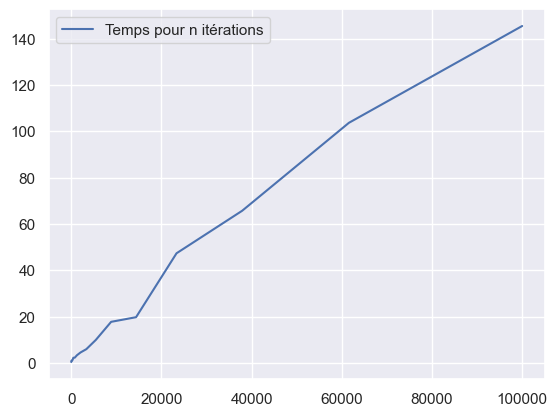

In [26]:
plt.plot(np.logspace(1,5,20).astype(int),temp_1)
plt.legend(["Temps pour n itérations"])
plt.show()

L'évolution est linéaire, en revanche à partir de 60 000 itérations, notre ordinateur perd en rapidité car le flot de données être trop important.

In [16]:
temp_2 = []
for N in tqdm((np.logspace(1,2,10)).astype(int)):
    t0 = time.time()
    res = simulation_house_1(1000,N,N,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e)
    temp_2.append(time.time()-t0)

100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


On regarde l'influence de la pièce sur le temps de calcul pour faire 1000 itérations. Pour cela on suppose un pièce de taille N x N. En faisant varier N, on regarde comme varie le temps de calcul.

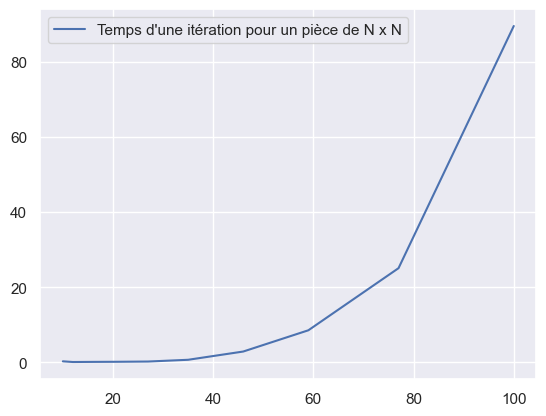

In [17]:
fig = plt.plot()
plt.plot(np.logspace(1,2,10).astype(int),temp_2)
plt.legend(["Temps d'une itération pour un pièce de N x N"])

On voit que le temps de simulation est exponentielle en fonction de N

# Simulation 1

In [18]:
Temp = {"in":20,
       "border":10,
       "rad":30}

In [19]:
Nx = 40
Ny = 40

e = 2
wall_in = [instance(Nx/2,Ny-2,Ny-e-1,Nx/2-e-1,Nx/2-e+1),instance(Nx/2,e,1,Nx/2-e-1,Nx/2-e+1),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0),instance(2,Ny/4,Ny/4-2,0,Nx/8),instance(Nx/4,Ny/4,Ny/4-2,0,Ny/2),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0),instance(2,Ny/2,Ny/2-2,0,Nx/8),instance(Nx/4,Ny/2,Ny/2-2,0,5*Ny/8),instance(3*Nx/8,Ny-2,Ny/2-2,2,2),instance(Nx/2,Ny/4,2,1,1)]
rad_in = []
window = [instance(Nx/2,Ny-2,Ny-e-1,0,Nx/4-e+1),instance(2,Ny-2,6*Ny/8,0,e)]


In [20]:
n = 10000

Nous allons dans un premier temps regarder une pièce sans mur, sans radiateur mais avec une fenêtre.

In [21]:
res = simulation_house_1(n,Nx,Ny,matiere,[],rad_in,window,Temp,dx,dy,dt,M,e)

RuntimeError: Requested MovieWriter (ffmpeg) not available

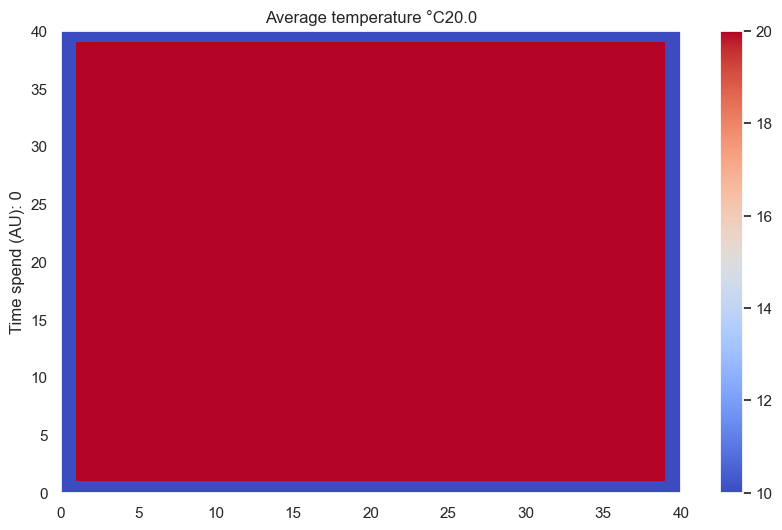

In [22]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time spend (AU): ' + str(i*50))
    ax.set_title('Average temperature °C' + str(np.round(average_room(vec_to_matrix(res[i],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, func = animate)

HTML(anim.to_html5_video())

Nous allons dans un premier temps regarder une pièce sans radiateur mais avec une fenêtre.

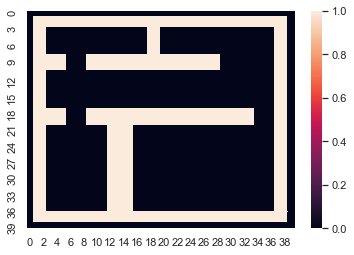

In [ ]:
affichage(vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["wall"] ,Nx,Ny),False)

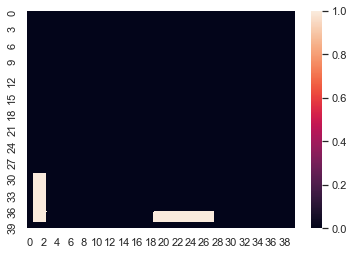

In [ ]:
affichage(vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["window"] ,Nx,Ny),False)

In [ ]:
res = simulation_house_1(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e)

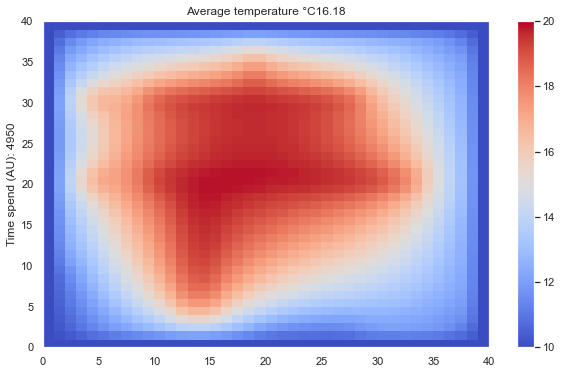

In [ ]:


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time spend (AU): ' + str(i*50))
    ax.set_title('Average temperature °C' + str(np.round(average_room(vec_to_matrix(res[i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, func = animate)

HTML(anim.to_html5_video())

# Simulation 2

On va maintenant ajouter des radiateurs.

In [ ]:
# definition de la pièce 

Nx = 40
Ny = 40

e = 2
wall_border = [instance(Nx/2,Ny-2,Ny-e-1,Nx/2-e-1,Nx/2-e+1),instance(Nx/2,e,1,Nx/2-e-1,Nx/2-e+1),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0)]
wall_in = [instance(2,Ny/4,Ny/4-2,0,Nx/8),instance(Nx/4,Ny/4,Ny/4-2,0,Ny/2),instance(2,Ny/2,Ny/2-2,0,Nx/8),instance(Nx/4,Ny/2,Ny/2-2,0,5*Ny/8),instance(3*Nx/8,Ny-2,Ny/2-2,2,2),instance(Nx/2,Ny/4,2,1,1)]

rad1 = instance(Nx-e,Ny-2*e,Ny-5*e,3,0)
rad2 = instance(Nx/2+2,Ny/4-3,3,1,1)
rad3 = instance(2*e,Ny-2*e,Ny-3*e,0,3*e)
rad4 = instance(Nx/2+2,Ny/2-3,Ny/2-4,3,3)
rad_in = [rad1,rad2,rad3,rad4]
window = [instance(Nx/2,Ny-2,Ny-e-1,0,Nx/4-e+1),instance(2,Ny-2,6*Ny/8,0,e)]


In [ ]:
wall_in_plot = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["wall"] ,Nx,Ny)*2
wall_border_plot = vec_to_matrix(house_border(Nx,Ny,e,wall_border,rad_in,window)["wall"] ,Nx,Ny)*2
window_print = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["window"] ,Nx,Ny)*10
rad_print = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["rad"] ,Nx,Ny)*4
all_plot_1 = wall_in_plot+window_print+rad_print+rad_print
all_plot_2 = wall_border_plot+wall_in_plot+window_print+rad_print

Les éléments intérieurs

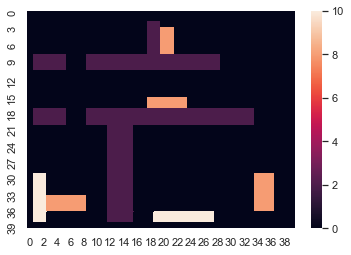

In [ ]:
affichage(all_plot_1,False)

In [ ]:
n=10000


In [ ]:
matiere = {
            "mur"   :  0.001,
            "air"   :  0.05,
            "vitre" :  10       # On augmente le coefficient associé à la conductivité thermique de la vitre pour mieux voir le phénomène
          }



In [ ]:
res = simulation_house_1(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e)

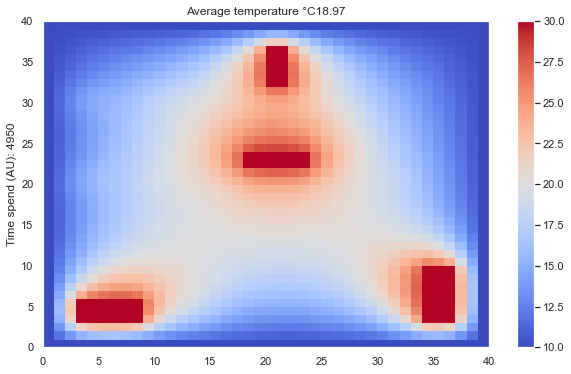

In [ ]:


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time spend (AU): ' + str(i*50))
    ax.set_title('Average temperature °C' + str(np.round(average_room(vec_to_matrix(res[i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, func = animate)

HTML(anim.to_html5_video())

# Simulation 3

On change les pramètres de simulation notamment en augmentant le coef de l'air

In [ ]:
matiere = {
            "mur"   :  0.1,
            "air"   :  0.05,
            "vitre" :  10       # On augmente le coefficient associé à la conductivité thermique de la vitre pour mieux voir le phénomène
          }

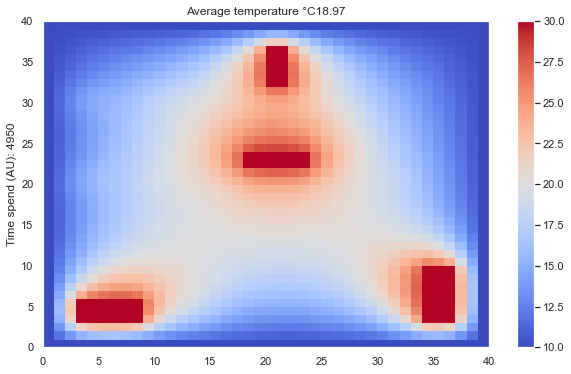

In [ ]:


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time spend (AU): ' + str(i*50))
    ax.set_title('Average temperature °C' + str(np.round(average_room(vec_to_matrix(res[i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, func = animate)

HTML(anim.to_html5_video())

# Simulation 4 

On remplace le problème de chauffage par un problème de climatisation

In [ ]:
Temp = {"in":20,
       "border":40,
       "rad":19}

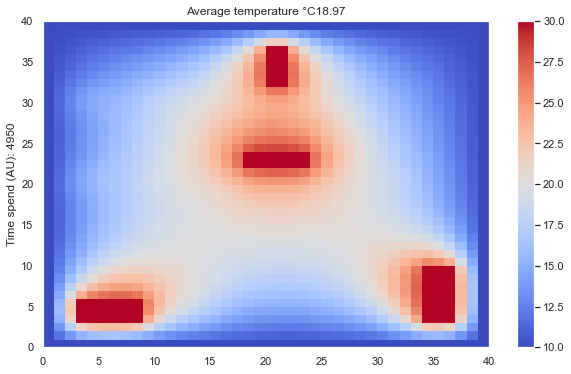

In [ ]:


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time spend (AU): ' + str(i*50))
    ax.set_title('Average temperature °C' + str(np.round(average_room(vec_to_matrix(res[i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, func = animate)

HTML(anim.to_html5_video())

# Simulation 5

On fait une simualtion où le chauffage peut s'allumer puis s'éteindre en fonction d'une température seuil

In [ ]:
Nx = 40
Ny = 40
n = 1000

In [ ]:
matiere = {
            "mur"   :  0.001,
            "air"   :  0.05,
            "vitre" :  0.5       
          }

In [ ]:
def generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,with_rad):
    A = np.zeros((Nx*Ny,Nx*Ny))
    compute_border = house_border(Nx,Ny,e,wall_in,rad_in,window)
    wall = compute_border["wall"]
    border = compute_border["border"]
    window = compute_border["window"]
    rad = compute_border["rad"]
    length = range(Nx*Ny)
    for k,b,w,f,r in list(zip(length,border,wall,window,rad)):
        if b or (r and with_rad):
            A[k,k]=M
        else:
            if f:
                mu = matiere["vitre"]
            elif w:
                mu = matiere["mur"]
            else:
                mu = matiere["air"]
            A[k,k]=dt*(1+2*mu*(1/(dx**2)+1/(dy**2)))
            A[k,k-1]=-mu*dt/(dx**2)
            A[k,k+1]=-mu*dt/(dx**2)
            A[k,k-Nx]=-mu*dt/(dy**2)
            A[k,k+Nx]=-mu*dt/(dy**2)
    return A

In [ ]:
Temp = {"in":18,
       "border":10,
       "rad":50}

In [ ]:
def simulation_evol(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e):
    # initialisation de la température 
    compute = house_border(Nx,Ny,e,wall_in,rad_in,window)
    is_border = compute["border"]
    is_rad = compute["rad"]
    T0 = np.array([Temp["in"]]*(Nx*Ny))
    T0[is_border]=Temp["border"]
    T0[is_rad]=Temp["rad"]
    T = [T0.copy()]
    A_inv1 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,True))
    A_inv2 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,False))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        if average_room(vec_to_matrix(T[i],Nx,Ny))<19:
            Tk_1[is_rad]=M*Temp["rad"]
            T.append(np.dot(A_inv1,Tk_1))
        else:
            T.append(np.dot(A_inv2,Tk_1))
    
    return T

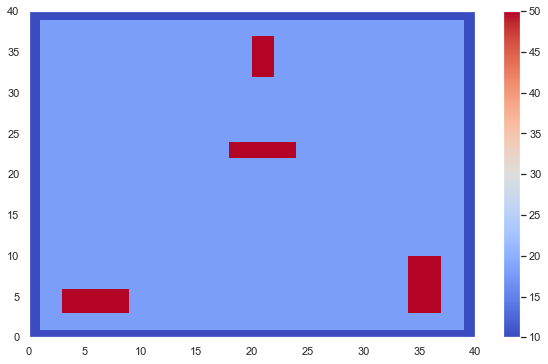

In [ ]:
res = simulation_evol(n,Nx,Ny,matiere,wall_in,rad_in,window,Temp,dx,dy,dt,M,e)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Time (s): ' + str(i))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[i],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[i],Nx,Ny)).flatten()) 
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

In [ ]:
HTML(anim.to_html5_video())

# Placement optimal du radiateur pour minimiser son temps d'allumage

In [ ]:
Temp = {"in":18,
       "border":5,
       "rad":50}

matiere = {
            "mur"   :  0.001,
            "air"   :  0.2,
            "vitre" :  10       
          }

In [ ]:
def simulation_evol_time(n,Nx,Ny,matiere,wall_in,Temp,rad_in,window,dx,dy,dt,M,e):
    # initialisation de la température 
    compute = house_border(Nx,Ny,e,wall_in,rad_in,window)
    tps = 1
    time = [1]
    is_border = compute["border"]
    is_rad = compute["rad"]
    T0 = np.array([Temp["in"]]*(Nx*Ny))
    T0[is_border]=Temp["border"]
    T0[is_rad]=Temp["rad"]
    T = [T0.copy()]
    A_inv1 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,True))
    A_inv2 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,False))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        if average_room(vec_to_matrix(T[i],Nx,Ny))<19:
            Tk_1[is_rad]=M*Temp["rad"]
            T.append(np.dot(A_inv1,Tk_1))
            tps+=1
            time.append(tps)
        else:
            T.append(np.dot(A_inv2,Tk_1))
            time.append(tps)
    
    return (T,time)

In [ ]:
Nx = 40
Ny = 40

e = 2
wall_border = [instance(Nx/2,Ny-2,Ny-e-1,Nx/2-e-1,Nx/2-e+1),instance(Nx/2,e,1,Nx/2-e-1,Nx/2-e+1),instance(2,Ny-2,1,0,e),instance(Nx,Ny-2,1,e,0)]
wall_in = [instance(2,Ny/4,Ny/4-2,0,Nx/8),instance(Nx/4,Ny/4,Ny/4-2,0,Ny/2),instance(2,Ny/2,Ny/2-2,0,Nx/8),instance(Nx/4,Ny/2,Ny/2-2,0,5*Ny/8),instance(3*Nx/8,Ny-2,Ny/2-2,2,2),instance(Nx/2,Ny/4,2,1,1)]


rad_in.clear()
for j in range (4):
    for i in range(6):
        rad_in.append(instance(Nx-(1+3*i)*e,Ny-(2+4*j)*e,Ny-(5+4*j)*e,3,0))



window = [instance(Nx/2,Ny-2,Ny-e-1,0,Nx/4-e+1),instance(2,Ny-2,6*Ny/8,0,e)]


In [ ]:
# variable pour affiche des élements d'une pièce

wall_in_plot = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["wall"] ,Nx,Ny)*18
wall_border_plot = vec_to_matrix(house_border(Nx,Ny,e,wall_border,rad_in,window)["wall"] ,Nx,Ny)*18
window_print = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["window"] ,Nx,Ny)*30
rad_plot = vec_to_matrix(house_border(Nx,Ny,e,wall_in,rad_in,window)["rad"] ,Nx,Ny)*40


rad_best1= vec_to_matrix(house_border(Nx,Ny,e,wall_in,[rad_in[-9]],window)["rad"] ,Nx,Ny)*10
rad_worst1 = vec_to_matrix(house_border(Nx,Ny,e,wall_in,[rad_in[0]],window)["rad"] ,Nx,Ny)*35
rad_best_border1 =  vec_to_matrix(house_border(Nx,Ny,e,wall_in,[rad_in[-3]],window)["rad"] ,Nx,Ny)*50


rad_best2= vec_to_matrix(house_border(Nx,Ny,e,wall_in,[rad_in[3]],window)["rad"] ,Nx,Ny)*35




all_plot_2 = wall_border_plot+window_print+rad_plot
all_plot_4 = wall_in_plot

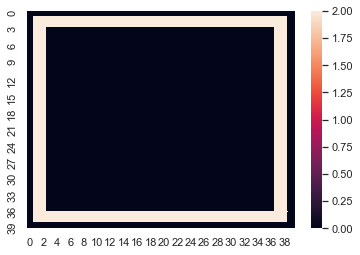

In [ ]:
affichage(vec_to_matrix(house_border(Nx,Ny,e,wall_border,rad_in,window)["wall"] ,Nx,Ny)*2,False)

Affichage des murs intérieurs

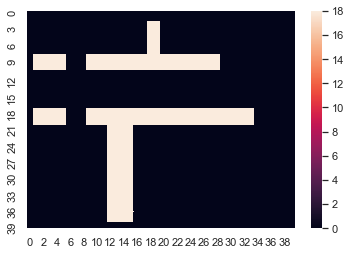

In [ ]:
affichage(all_plot_4,False)

Pièce sans les murs intérieurs

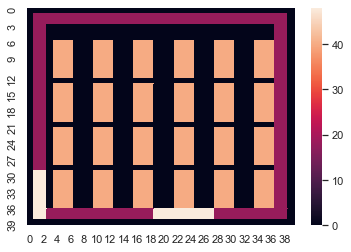

In [ ]:
affichage(all_plot_2,False)

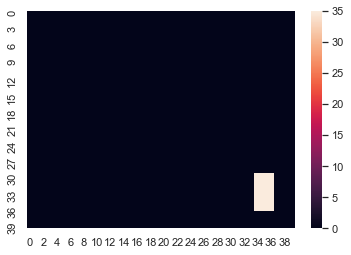

In [ ]:
affichage(vec_to_matrix(house_border(Nx,Ny,e,wall_in,[rad_in[0]],window)["rad"] ,Nx,Ny)*35)

In [ ]:
n = 5000

On teste toutes les positions pour les murs pour voir le temps où ils sont allumés

Sans les murs dans la pièce

In [ ]:
t_without_wall_in = []
for rad in tqdm(rad_in) : 
    t_without_wall_in.append(simulation_evol_time(n,Nx,Ny,matiere,wall_border,Temp,[rad],window,dx,dy,dt,M,e)[1][-1])

100%|██████████| 24/24 [03:05<00:00,  7.74s/it]


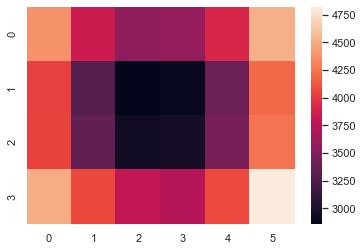

In [ ]:
affichage(vec_to_matrix(np.flipud(np.array(t_without_wall_in)),6,4),False)

In [ ]:
res = simulation_evol_time(n,Nx,Ny,matiere,wall_border,Temp,[rad_in[14]],window,dx,dy,dt,M,e)

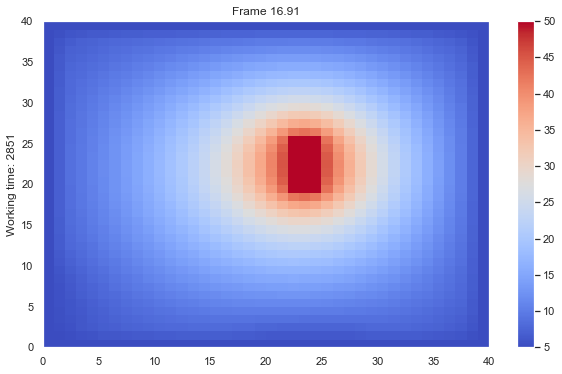

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0][0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Working time: ' + str(res[1][i*50]))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[0][i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[0][i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

HTML(anim.to_html5_video())

Avec les murs dans la pièce

In [ ]:
t_with_wall_in = []
for rad in tqdm(rad_in) : 
    t_with_wall_in.append(simulation_evol_time(n,Nx,Ny,matiere,wall_border+wall_in,Temp,[rad],window,dx,dy,dt,M,e)[1][-1])

100%|██████████| 24/24 [03:02<00:00,  7.61s/it]


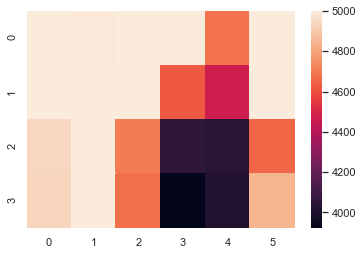

In [ ]:
affichage(vec_to_matrix(np.flipud(np.array(t_with_wall_in)),6,4),False)

In [ ]:
res = simulation_evol_time(n,Nx,Ny,matiere,wall_border+wall_in,Temp,[rad_in[4]],window,dx,dy,dt,M,e)

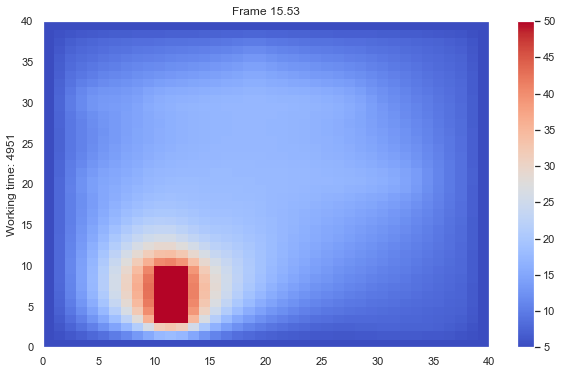

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0][0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Working time: ' + str(res[1][i*50]))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[0][i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[0][i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

HTML(anim.to_html5_video())

# Placement optimale d'une climatisation

In [ ]:
n = 10000

In [ ]:
20+13

33

In [ ]:
Temp = {"in":20,
       "border":33,
       "rad":-12}

In [ ]:
def simulation_evol_time(n,Nx,Ny,matiere,wall_in,Temp,rad_in,window,dx,dy,dt,M,e):
    # initialisation de la température 
    compute = house_border(Nx,Ny,e,wall_in,rad_in,window)
    tps = 1
    time = [1]
    is_border = compute["border"]
    is_rad = compute["rad"]
    T0 = np.array([Temp["in"]]*(Nx*Ny))
    T0[is_border]=Temp["border"]
    T0[is_rad]=Temp["rad"]
    T = [T0.copy()]
    A_inv1 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,True))
    A_inv2 = np.linalg.inv(generator_A_house_evol(Nx,Ny,matiere,wall_in,rad_in,window,dx,dy,dt,M,e,False))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        if average_room(vec_to_matrix(T[i],Nx,Ny))>19:
            Tk_1[is_rad]=M*Temp["rad"]
            T.append(np.dot(A_inv1,Tk_1))
            tps+=1
            time.append(tps)
        else:
            T.append(np.dot(A_inv2,Tk_1))
            time.append(tps)
    
    return (T,time)

In [ ]:
res = simulation_evol_time(n,Nx,Ny,matiere,wall_border,Temp,[rad_in[0]],window,dx,dy,dt,M,e)

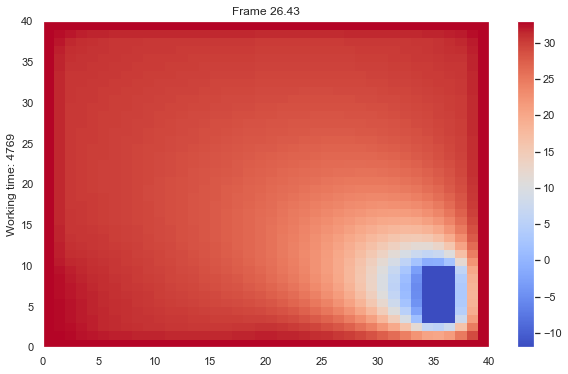

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0][0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Working time: ' + str(res[1][i*50]))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[0][i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[0][i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

HTML(anim.to_html5_video())

In [ ]:
n = 5000

In [ ]:
t_clim_without_wall_in = []
for rad in tqdm(rad_in) : 
    t_clim_without_wall_in.append(simulation_evol_time(n,Nx,Ny,matiere,wall_border,Temp,[rad],window,dx,dy,dt,M,e)[1][-1])

100%|██████████| 24/24 [03:01<00:00,  7.57s/it]


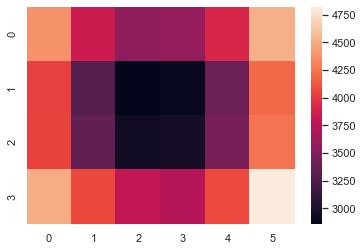

In [ ]:
affichage(vec_to_matrix(np.flipud(np.array(t_clim_without_wall_in)),6,4),False)

In [ ]:
res = simulation_evol_time(n,Nx,Ny,matiere,wall_border,Temp,[rad_in[15]],window,dx,dy,dt,M,e)

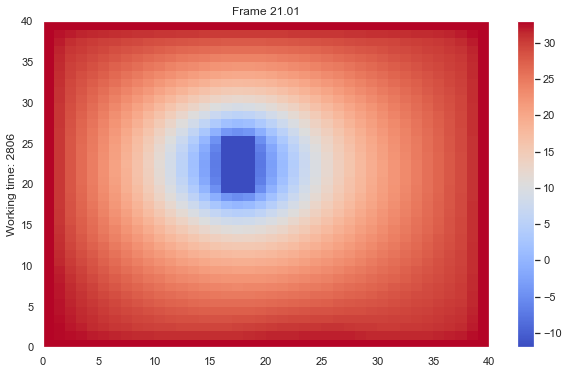

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0][0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Working time: ' + str(res[1][i*50]))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[0][i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[0][i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

HTML(anim.to_html5_video())

In [ ]:
t_clim_with_wall_in = []
for rad in tqdm(rad_in) : 
    t_clim_with_wall_in.append(simulation_evol_time(n,Nx,Ny,matiere,wall_border+wall_in,Temp,[rad],window,dx,dy,dt,M,e)[1][-1])

100%|██████████| 24/24 [03:05<00:00,  7.75s/it]


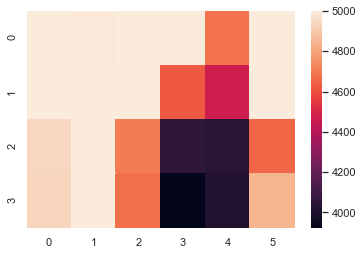

In [ ]:
affichage(vec_to_matrix(np.flipud(np.array(t_clim_with_wall_in)),6,4),False)

In [ ]:
res = simulation_evol_time(n,Nx,Ny,matiere,wall_border+wall_in,Temp,[rad_in[15]],window,dx,dy,dt,M,e)

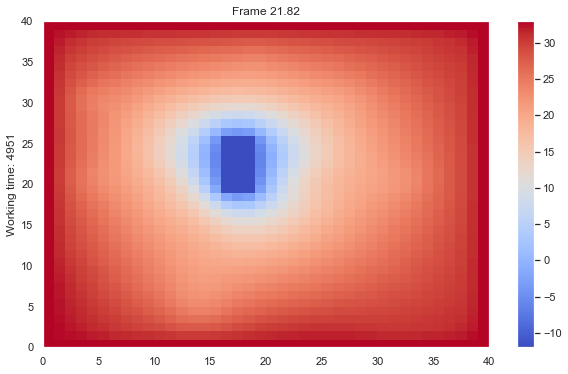

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, Nx), ylim=(0, Ny))

cax = ax.pcolormesh(np.flipud(vec_to_matrix(res[0][0],Nx,Ny)),cmap="coolwarm")
fig.colorbar(cax)


def animate(i):
    ax.set_ylabel('Working time: ' + str(res[1][i*50]))
    ax.set_title('Frame ' + str(np.round(average_room(vec_to_matrix(res[0][i*50],Nx,Ny)),2)))
    cax.set_array(np.flipud(vec_to_matrix(res[0][i*50],Nx,Ny)).flatten()) 
    
    
anim = animation.FuncAnimation(
    fig, animate, interval=100)

HTML(anim.to_html5_video())

# Modèlisation 3D

In [ ]:
Nx = 15
Ny = 15
Nz = 15

In [ ]:
matiere = {
            "mur"   :  0.001,
            "air"   :  0.05,
            "vitre" :  10       
          }

In [ ]:
def vec_to_matrix_3D(k,Nx,Ny,Nz):              # Entrée : k un vecteur, Nx nombre de points de la matrice suivant x, Ny suivant y
    return np.array(k).reshape(Nz,Ny,Nx) 

In [ ]:
def plot_3D(val,Nx,Ny,Nz):
    X, Y, Z = np.mgrid[1:Nx+1, 1:Ny+1, 1:Nz+1]
    values = val
    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=values.flatten(),
        opacity=0.04, # needs to be small to see through all surfaces
        surface_count=15, # needs to be a large number for good volume rendering
        colorscale='BlueRed'
        ))
    
    fig.update_layout(scene_camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0.1, y=2.5, z=0.1)))
    
    fig.show()

In [ ]:
def k_border_3D(Nx,Ny,Nz):
    
    # Entrée : 
    #          - Nx, Ny la dimension de la pièce (en nombre de points)
    # Sortie :
    #          - res : un vecteur de booléen qui indique pour chaque point si il se situe sur la bordure
    
    shape = (np.zeros((Nx, Ny, Nz))+1).astype(bool)
        
    
    for i in range(1,Nz-1):
        shape[i][1:-1,1:-1]=False
    
    return shape.ravel()

In [ ]:
plot_3D(vec_to_matrix_3D(k_border_3D(Nx,Ny,Nz),Nx,Ny,Nz)*1,Nx,Ny,Nz)

In [ ]:
def k_wall_3D(Nx,Ny,Nz,e):
    
    # Entrée : 
    #          - Nx, Ny la dimension de la pièce (en nombre de points)
    # Sortie :
    #          - res : un vecteur de booléen qui indique pour chaque point si il se situe sur la bordure
    
    shape = (np.zeros((Nx, Ny, Nz))).astype(bool)
    for i in range(1,e+1):
        shape[i][1:-1,1:-1] = True
        shape[-(i+1)][1:-1,1:-1] = True
    for i in range(e+1,Nz-e-1):
        shape[i][1:-1,1:-1]=True
        shape[i][e:-e,e:-e]=False
    
    return shape.ravel()

In [ ]:
plot_3D(vec_to_matrix_3D(k_wall_3D(Nx,Ny,Nz,e),Nx,Ny,Nz)*1,Nx,Ny,Nz)

In [ ]:
def generator_cube_3D(Nx,Ny,Nz,matiere,rad,window,dx,dy,dz,dt,M,e):
    A = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
    border = k_border_3D(Nx,Ny,Nz)
    length = range(Nx*Ny*Nz)
    wall = k_wall_3D(Nx,Ny,Nz,e)
    for k,b,f,r,w in list(zip(length,border,window,rad,wall)):
        if b or r:
            A[k,k] = M
        else:
            if f:
                mu = matiere["vitre"]
            elif w:
                mu = matiere["mur"]
            else:
                mu = matiere["air"]
                
            A[k,k]=dt*(1+2*mu*(1/(dx**2)+1/(dy**2)+1/(dz**2)))
            A[k,k-1]=-mu*dt/(dx**2)
            A[k,k+1]=-mu*dt/(dx**2)
            A[k,k-Nx]=-mu*dt/(dy**2)
            A[k,k+Nx]=-mu*dt/(dy**2)
            A[k,k-Nx*Ny]=-mu*dt/(dz**2)
            A[k,k+Nx*Ny]=-mu*dt/(dz**2)
    return A

In [ ]:
def simulation_3D(n,Nx,Ny,Nz,matiere,rad,window,dx,dy,dz,dt,M,e):
    # initialisation de la température 
    is_border = k_border_3D(Nx,Ny,Nz)
    is_rad = rad
    T0 = np.array([20]*(Nx*Ny*Nz))
    T0[is_border]=10
    T0[is_rad]=30
    T = [T0.copy()]
    A_inv = np.linalg.inv(generator_cube_3D(Nx,Ny,Nz,matiere,rad,window,dx,dy,dz,dt,M,e))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        Tk_1[is_rad]=Tk_1[is_rad]*M
        T.append(np.dot(A_inv,Tk_1))
    
    return T


In [ ]:
shape = (np.zeros((Nx, Ny, Nz))).astype(bool)
for i in range(1,e+1):
    shape[Nz-i-1][int(Nx/4):-int(Nx/4),int(Ny/4):-int(Ny/4)] =True
rad = shape.ravel()
plot_3D(rad*1,Nx,Ny,Nz)



shape = (np.zeros((Nx, Ny, Nz))).astype(bool)
for i in range(1,e+1):
    shape[i][int(Nx/4):-int(Nx/4),int(Ny/4):-int(Ny/4)] =True
window_front = shape.ravel()
plot_3D(window_front*1,Nx,Ny,Nz)



shape = (np.zeros((Nx, Ny, Nz))).astype(bool)
for i in range(int(Nx/4),int(3*Nx/4)):
    shape[i][int(Nx/4):int(3*Nx/4),1:e+1] =True
window_down = shape.ravel()

plot_3D(window_down*1,Nx,Ny,Nz)


shape = (np.zeros((Nx, Ny, Nz))).astype(bool)
for i in range(8,9):
    shape[i] =True
    shape[i][int(Nx/4):-int(Nx/4),int(Ny/4):-int(Ny/4)] = False
window_middle = shape.ravel()

plot_3D(window_middle,Nx,Ny,Nz)

In [ ]:
res = simulation_3D(1000,Nx,Ny,Nz,matiere,window_down,window_front,dx,dy,dz,dt,M,e)

In [ ]:
plot_3D(vec_to_matrix_3D(res[500],Nx,Ny,Nz),Nx,Ny,Nz)

# simulation avec le trou

In [ ]:
def generator_cube_3D_trou(Nx,Ny,Nz,matiere,rad,border_middle,dx,dy,dz,dt,M,e):
    A = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
    length = range(Nx*Ny*Nz)
    border = k_border_3D(Nx,Ny,Nz)+border_middle
    wall = k_wall_3D(Nx,Ny,Nz,e)
   
    for k,b,r,w in list(zip(length,border,rad,wall)):
        if r or b:
            A[k,k] = M
        else:
            if w:
                mu = matiere["mur"]
            else:
                mu = matiere["air"]
                
            A[k,k]=dt*(1+2*mu*(1/(dx**2)+1/(dy**2)+1/(dz**2)))
            A[k,k-1]=-mu*dt/(dx**2)
            A[k,k+1]=-mu*dt/(dx**2)
            A[k,k-Nx]=-mu*dt/(dy**2)
            A[k,k+Nx]=-mu*dt/(dy**2)
            A[k,k-Nx*Ny]=-mu*dt/(dz**2)
            A[k,k+Nx*Ny]=-mu*dt/(dz**2)
    return A

In [ ]:
def simulation_3D_trou(n,Nx,Ny,Nz,matiere,rad,border_middle,dx,dy,dz,dt,M,e):
    # initialisation de la température 
    is_border = k_border_3D(Nx,Ny,Nz)+border_middle
    is_rad = rad
    T0 = np.array([20]*(Nx*Ny*Nz))
    T0[is_border]=10
    T0[is_rad]=30
    T = [T0.copy()]
    A_inv = np.linalg.inv(generator_cube_3D_trou(Nx,Ny,Nz,matiere,rad,window_middle,dx,dy,dz,dt,M,e))
    for i in range(n):
        Tk_1 = T[i].copy()
        Tk_1[is_border]=Tk_1[is_border]*M
        Tk_1[is_rad]=Tk_1[is_rad]*M
        T.append(np.dot(A_inv,Tk_1))
    
    return T


In [ ]:
res = simulation_3D_trou(1000,Nx,Ny,Nz,matiere,rad,window_middle,dx,dy,dz,dt,M,e)

In [ ]:
plot_3D(vec_to_matrix_3D(res[1000],Nx,Ny,Nz),Nx,Ny,Nz)